# Data Cleaning

We determined in our EDA that the dataset from The Numbers will be our target list of movies to analyze, as we really like the profitability measures it provides.

We also like the features that the IMDB set provides for movies, and would like to get the IMDB data for all the movies in our target set to use in our analysis.

In this notebook we prepare our master data set by doing the following:
   - Load in and clean The Numbers dataset
   - Query our IMDB dataset and clean it up
   - Load in supplemental IMDB data that we pulled from Kaggle
   - Combine all data and export cleaned master data set

### Imports

In [1]:
import pandas as pd
import sqlite3
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.0f}'.format

In [2]:
# To silence the very annoying 'Copy on a Slice' warnings
import warnings
warnings.simplefilter('ignore')

### The Numbers Dataset

Let's load in our target list and clean it up a bit!

In [3]:
tn_budgets = pd.read_csv('../zippedData/tn.movie_budgets.csv.gz', parse_dates=['release_date'], encoding='utf-8')

tn_budgets.head(2)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,2009-12-18,Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"


Because movie tastes have changed drastically over time, we decided to exclude movies released before the year 2000.

In [4]:
# Create release year
tn_budgets['release_year'] = tn_budgets['release_date'].dt.year

# Filter out movies before 2000
tn_clean = tn_budgets[tn_budgets['release_year'] >= 2000]

tn_clean.head(2)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year
0,1,2009-12-18,Avatar,"$425,000,000","$760,507,625","$2,776,345,279",2009
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",2011


We want to add features for Gross Profit and Gross ROI, but in order to calculate them we will need to convert the budget and revenue measures to floats. 

In [5]:
# Using lambda to convert the strings to floats after stripping the dollar signs and commas

tn_clean['production_budget'] = tn_clean['production_budget'].apply(
    lambda x: float(x.replace('$', '').replace(',', '')))

tn_clean['domestic_gross'] = tn_clean['domestic_gross'].apply(
    lambda x: float(x.replace('$', '').replace(',', '')))

tn_clean['worldwide_gross'] = tn_clean['worldwide_gross'].apply(
    lambda x: float(x.replace('$', '').replace(',', '')))

# Calculating gross profit
tn_clean['Global_Gross_Profit'] = tn_clean['worldwide_gross'] - tn_clean['production_budget']

# Calculating gross ROI
tn_clean['Global_Gross_ROI'] = (tn_clean['Global_Gross_Profit'] / tn_clean['production_budget'])

tn_clean.head(2)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,Global_Gross_Profit,Global_Gross_ROI
0,1,2009-12-18,Avatar,425000000,760507625,2776345279,2009,2351345279,6
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011,635063875,2


Now let's drop some columns and clean up the remaining ones.

In [6]:
# Drop the unnecessary columns
tn_clean = tn_clean.drop(columns=['id', 'release_date'])

# Let's use a dictionary to rename our columns to match our other dataset
rename_dict = {'movie':'Title', 'production_budget':'Budget', 'domestic_gross':'Domestic_Gross_Rev', 
               'worldwide_gross':'Global_Gross_Rev', 'release_year':'Year'}

tn_clean = tn_clean.rename(columns=rename_dict)

tn_clean.head(10)

,Title,Budget,Domestic_Gross_Rev,Global_Gross_Rev,Year,Global_Gross_Profit,Global_Gross_ROI
0,Avatar,425000000,760507625,2776345279,2009,2351345279,6
1,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011,635063875,2
2,Dark Phoenix,350000000,42762350,149762350,2019,-200237650,-1
3,Avengers: Age of Ultron,330600000,459005868,1403013963,2015,1072413963,3
4,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,2017,999721747,3
5,Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,2015,1747311220,6
6,Avengers: Infinity War,300000000,678815482,2048134200,2018,1748134200,6
7,Pirates of the Caribbean: At Worldâs End,300000000,309420425,963420425,2007,663420425,2
8,Justice League,300000000,229024295,655945209,2017,355945209,1
9,Spectre,300000000,200074175,879620923,2015,579620923,2


Huh? Looks like an encoding error in the Title column, 7th index...

In [7]:
tn_clean['Title'].values.tolist()

['Avatar',
 'Pirates of the Caribbean: On Stranger Tides',
 'Dark Phoenix',
 'Avengers: Age of Ultron',
 'Star Wars Ep. VIII: The Last Jedi',
 'Star Wars Ep. VII: The Force Awakens',
 'Avengers: Infinity War',
 'Pirates of the Caribbean: At Worldâ\x80\x99s End',
 'Justice League',
 'Spectre',
 'The Dark Knight Rises',
 'Solo: A Star Wars Story',
 'The Lone Ranger',
 'John Carter',
 'Tangled',
 'Spider-Man 3',
 'Captain America: Civil War',
 'Batman v Superman: Dawn of Justice',
 'The Hobbit: An Unexpected Journey',
 'Harry Potter and the Half-Blood Prince',
 'The Hobbit: The Desolation of Smaug',
 'The Hobbit: The Battle of the Five Armies',
 'The Fate of the Furious',
 'Superman Returns',
 'Pirates of the Caribbean: Dead Men Tell No Tales',
 'Quantum of Solace',
 'The Avengers',
 'Pirates of the Caribbean: Dead Manâ\x80\x99s Chest',
 'Man of Steel',
 'The Chronicles of Narnia: Prince Caspian',
 'The Amazing Spider-Man',
 'Battleship',
 'Transformers: The Last Knight',
 'Jurassic World

We definitely found an encoding issue here. After trying various ways to normalize it or find the ideal encoding parameter to read the data in with, we were not able to fix it. 

Luckily, we identified 3 distinct patterns, each corresponding to its own misread character. We wrote a manual normalize function here to solve this problem. Put some lipstick on that pig!

In [8]:
# Write manual normalizer to fix these encoding issues
def normalize_text(text):
    return text.replace('â\x80\x99', "'").replace('â\x80\x94', " ").replace('Ã©', "e")

# Apply the function to clean up the Title column
tn_clean['Title'] = tn_clean['Title'].apply(lambda x: normalize_text(x))

tn_clean.head(10)

,Title,Budget,Domestic_Gross_Rev,Global_Gross_Rev,Year,Global_Gross_Profit,Global_Gross_ROI
0,Avatar,425000000,760507625,2776345279,2009,2351345279,6
1,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011,635063875,2
2,Dark Phoenix,350000000,42762350,149762350,2019,-200237650,-1
3,Avengers: Age of Ultron,330600000,459005868,1403013963,2015,1072413963,3
4,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,2017,999721747,3
5,Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,2015,1747311220,6
6,Avengers: Infinity War,300000000,678815482,2048134200,2018,1748134200,6
7,Pirates of the Caribbean: At World's End,300000000,309420425,963420425,2007,663420425,2
8,Justice League,300000000,229024295,655945209,2017,355945209,1
9,Spectre,300000000,200074175,879620923,2015,579620923,2


Looking good! Lastly we will get a list of target movies to use to filter our IMDB data. Then we get querying...

In [9]:
tn_clean['Title & Year'] = tn_clean.apply(lambda row: f"{row['Title']} - {row['Year']}", axis=1)

In [10]:
# Get normalized list
target_list = [normalize_text(i) for i in tn_clean['Title'].values.tolist()]
len(target_list)

4387

In [11]:
target_list_with_years = [normalize_text(i) for i in tn_clean['Title & Year'].values.tolist()]

### IMDB Dataset

In [12]:
import os
import zipfile

# Check if 'im.db' exists, unzip if it doesn't
if not os.path.exists('../zippedData/im.db'):
    with zipfile.ZipFile('../zippedData/im.db.zip', 'r') as zip_ref:
        zip_ref.extractall('../zippedData')

# Connect to the SQLite database
conn = sqlite3.connect('../zippedData/im.db')

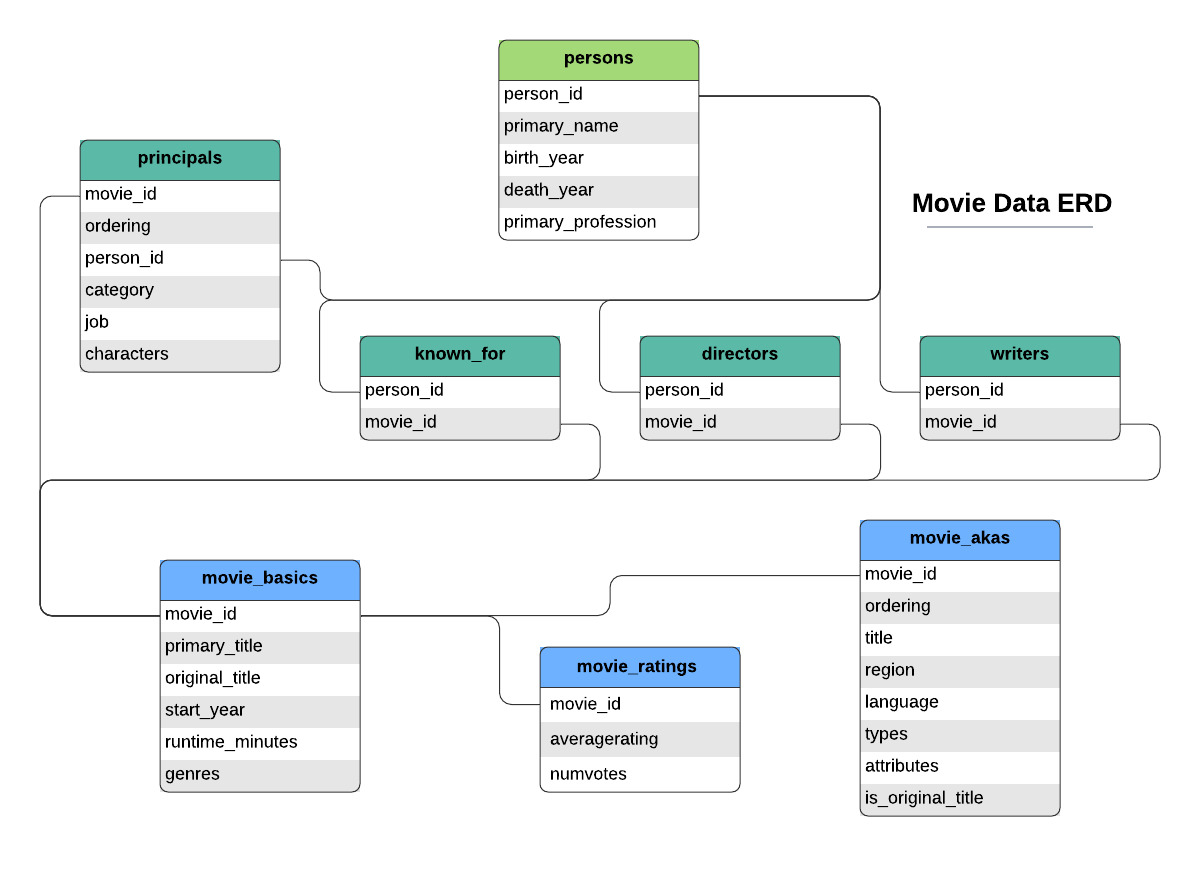

Explain here our process for building this massive query testing

In [13]:
# Here's our big query
movies_sql = pd.read_sql("""

WITH big_table AS (
    SELECT 
        mb.movie_id,
        mb.primary_title,
        mb.start_year,
        mb.runtime_minutes,
        mb.genres,
        mr.averagerating,
        mr.numvotes
    FROM movie_basics AS mb
        JOIN movie_ratings AS mr
            USING(movie_id)
        JOIN principals AS pr
            USING(movie_id)
        JOIN persons AS ps
            USING(person_id)
    WHERE mb.start_year > 2000
    GROUP BY mb.movie_id
    
),

ActorNames AS (
    SELECT 
        DISTINCT p.movie_id, 
        GROUP_CONCAT(pe.primary_name) AS Actors
    FROM principals p
        JOIN persons pe
            USING(person_id)
    WHERE p.category IN ('actor', 'actress', 'self')
    GROUP BY p.movie_id
),

WriterNames AS (
    SELECT 
        DISTINCT p.movie_id, 
        GROUP_CONCAT(pe.primary_name) AS Writers
    FROM principals p
        JOIN persons pe
            USING(person_id)
    WHERE p.category IN ('writer')
    GROUP BY p.movie_id
),

DirectorNames AS (
    SELECT 
        DISTINCT p.movie_id,
        GROUP_CONCAT(pe.primary_name) AS Directors
    FROM principals p
        JOIN persons pe
            USING(person_id)
    WHERE p.category IN ('director')
    GROUP BY p.movie_id
),

ProducerNames AS (
    SELECT 
        DISTINCT p.movie_id,
        GROUP_CONCAT(pe.primary_name) AS Producers
    FROM principals p
        JOIN persons pe
            USING(person_id)
    WHERE p.category IN ('producer')
    GROUP BY p.movie_id
)

    SELECT 
        b.movie_id AS ID,
        b.primary_title AS Title,
        b.start_year AS Year,
        b.runtime_minutes AS Runtime,
        b.genres AS Genres,
        b.averagerating AS AvgRating,
        b.numvotes AS VoteCount,
        a.Actors,
        w.Writers,
        d.Directors,
        p.Producers
    FROM big_table b
        JOIN ActorNames a
            USING(movie_id)
        JOIN WriterNames w
            USING(movie_id)
        JOIN DirectorNames d
            USING(movie_id)
        JOIN ProducerNames p
            USING(movie_id)
    ORDER BY b.primary_title
  ;
  """, conn)

In [14]:
movies_sql.head()

,ID,Title,Year,Runtime,Genres,AvgRating,VoteCount,Actors,Writers,Directors,Producers
0,tt2346170,#1 Serial Killer,2013,87,Horror,6,40,"Jason Tobin,Eugenia Yuan,Tzi Ma,Shoshana Bush",Koji Steven Sakai,Stanley Yung,Quentin Lee
1,tt5255986,#66,2015,116,Action,5,18,"Ari Riski Ananda,Erwin Bagindo,Fandy Christian...",Matthew Ryan Fischer,Asun Mawardi,Gina Maria
2,tt5803530,#DigitalLivesMatter,2016,nan,Comedy,6,19,"Rashan Ali,Carlos Aviles,Brooklyn Beedles,Ben ...",Cas Sigers-Beedles,Terri J. Vaughn,"Bobby Patterson,David Banner,D.C. Young Fly,An..."
3,tt5460468,#Enough,2015,nan,Drama,2,7,"Mark Boyd,Jebediah Calhoun,Sean Davis,Adriane ...",Damion Stevenson,Miranda Ferguson,"John Boudreau,Joseph Calhoun"
4,tt5233106,#FollowFriday,2016,90,Thriller,3,186,"Courtney Lakin,Joseph Poliquin,Ashley Bratcher...","Marie Bertonneau,Anna Rasmussen",Micho Rutare,David Michael Latt


In [15]:
movies_sql.shape

(21414, 11)

Phew, it worked. That's a lot of movies. Let's exclude all records here that are not for movies in our target list. 

In [16]:
# Slice our DataFrame to exclude movies not in our target list
movies_sql = movies_sql[movies_sql['Title'].isin(target_list) == True]
movies_sql.shape

(1446, 11)

After filtering with our target list, we only have 1446 records. We're glad it's more manageable, but we clearly don't have the features to analyze for all 4387 of our target movies.

... So we went looking for more. We found more IMDB data (a whole lot more) on kaggle, linked [here](https://www.kaggle.com/datasets/ashirwadsangwan/imdb-dataset?select=title.akas.tsv).

We worked with this set in another notebook and import the cleaned data below to merge with our existing data.

### More IMDB Data

In [17]:
# Load it up
imdb_extra = pd.read_csv('../cleanedData/imdb_supplemental_cleaned.csv')
imdb_extra.head(2)

,Unnamed: 0,ID,Title,Year,Runtime,Genres,AvgRating,VoteCount,Directors,Producers,Writers,Actors
0,0,tt0118589,Glitter,2001,104,"Drama,Music,Romance",2,23898,Vondie Curtis-Hall,Laurence Mark,"Cheryl L. West, Kate Lanier","Mariah Carey, Eric Benét, Max Beesley, Da Brat"
1,1,tt0120166,The Sorcerer's Apprentice,2001,86,"Adventure,Family,Fantasy",4,653,David Lister,"Elizabeth Matthews, Peter H. Matthews",Brett Morris,"Robert Davi, Kelly LeBrock, Byron Taylor, Roxa..."


In [18]:
# Get rid of that pesky Unnamed column
del imdb_extra['Unnamed: 0']
imdb_extra.head(2)

,ID,Title,Year,Runtime,Genres,AvgRating,VoteCount,Directors,Producers,Writers,Actors
0,tt0118589,Glitter,2001,104,"Drama,Music,Romance",2,23898,Vondie Curtis-Hall,Laurence Mark,"Cheryl L. West, Kate Lanier","Mariah Carey, Eric Benét, Max Beesley, Da Brat"
1,tt0120166,The Sorcerer's Apprentice,2001,86,"Adventure,Family,Fantasy",4,653,David Lister,"Elizabeth Matthews, Peter H. Matthews",Brett Morris,"Robert Davi, Kelly LeBrock, Byron Taylor, Roxa..."


In [19]:
# Here's our SQL data
movies_sql.head(2)

,ID,Title,Year,Runtime,Genres,AvgRating,VoteCount,Actors,Writers,Directors,Producers
47,tt1179933,10 Cloverfield Lane,2016,103,"Drama,Horror,Mystery",7,260383,"John Goodman,Mary Elizabeth Winstead,John Gall...","Josh Campbell,Matthew Stuecken,Damien Chazelle",Dan Trachtenberg,"Lindsey Weber,J.J. Abrams"
103,tt1413492,12 Strong,2018,130,"Action,Drama,History",7,50155,"Chris Hemsworth,Michael Shannon,Michael Peña,N...","Ted Tally,Peter Craig,Doug Stanton",Nicolai Fuglsig,"Thad Luckinbill,Jerry Bruckheimer"


Let's concatenate!

In [20]:
combined = pd.concat([movies_sql, imdb_extra])

In [21]:
combined.drop_duplicates(subset='ID', keep='first', inplace=True)

In [22]:
combined['Year'] = combined['Year'].astype(int)

In [23]:
combined['Title & Year'] = combined.apply(lambda row: f"{row['Title']} - {row['Year']}", axis=1)

In [24]:
# Slice our DataFrame to exclude movies not in our target list
combined = combined[combined['Title & Year'].isin(target_list_with_years) == True]
combined.shape

(3202, 12)

In [25]:
combined

,ID,Title,Year,Runtime,Genres,AvgRating,VoteCount,Actors,Writers,Directors,Producers,Title & Year
47,tt1179933,10 Cloverfield Lane,2016,103,"Drama,Horror,Mystery",7,260383,"John Goodman,Mary Elizabeth Winstead,John Gall...","Josh Campbell,Matthew Stuecken,Damien Chazelle",Dan Trachtenberg,"Lindsey Weber,J.J. Abrams",10 Cloverfield Lane - 2016
103,tt1413492,12 Strong,2018,130,"Action,Drama,History",7,50155,"Chris Hemsworth,Michael Shannon,Michael Peña,N...","Ted Tally,Peter Craig,Doug Stanton",Nicolai Fuglsig,"Thad Luckinbill,Jerry Bruckheimer",12 Strong - 2018
105,tt2024544,12 Years a Slave,2013,134,"Biography,Drama,History",8,577301,"Chiwetel Ejiofor,Michael Kenneth Williams,Mich...","John Ridley,Solomon Northup",Steve McQueen,"Jeremy Kleiner,Dede Gardner,Anthony Katagas",12 Years a Slave - 2013
108,tt1542344,127 Hours,2010,94,"Adventure,Biography,Drama",8,323949,"James Franco,Amber Tamblyn,Kate Mara,Sean Bott","Simon Beaufoy,Aron Ralston",Danny Boyle,"Christian Colson,John Smithson",127 Hours - 2010
114,tt2059171,13 Sins,2014,93,"Horror,Thriller",6,29550,"Mark Webber,Devon Graye,Tom Bower,Rutina Wesley","David Birke,Chookiat Sakveerakul,Eakasit Thairaat",Daniel Stamm,"Kiki Miyake,Brian Kavanaugh-Jones",13 Sins - 2014
...,...,...,...,...,...,...,...,...,...,...,...,...
6588,tt8632862,Fahrenheit 11/9,2018,128,Documentary,7,20066,"Brooke Baldwin, Ashleigh Banfield",NaN,Michael Moore,"Carl Deal, Meghan O'Hara",Fahrenheit 11/9 - 2018
6618,tt8852552,Icarus,2010,78,Thriller,nan,nan,NaN,Emile Beulen,Maarten Diederen,NaN,Icarus - 2010
6646,tt9024106,Unplanned,2019,109,"Biography,Drama",6,14481,"Ashley Bratcher, Brooks Ryan, Robia Scott, Jar...",Abby Johnson,"Chuck Konzelman,Cary Solomon","Daryl C. Lefever, Chris Jones, Joe Knopp",Unplanned - 2019
6683,tt9347476,Believe,2016,\N,\N,nan,nan,"Eleanor Scarlett Tutt, Ellie Bindman, Kira Cap...",NaN,NaN,NaN,Believe - 2016


### Add in our target data

In [26]:
# Merge tn_clean with combined table 
df_master = tn_clean.merge(combined, on=['Title', 'Year', 'Title & Year'], how='inner')

In [27]:
df_master.head()

,Title,Budget,Domestic_Gross_Rev,Global_Gross_Rev,Year,Global_Gross_Profit,Global_Gross_ROI,Title & Year,ID,Runtime,Genres,AvgRating,VoteCount,Actors,Writers,Directors,Producers
0,Avatar,425000000,760507625,2776345279,2009,2351345279,6,Avatar - 2009,tt0499549,162,"Action,Adventure,Fantasy",8,1359426,"Sam Worthington, Zoe Saldana, Sigourney Weaver...",NaN,James Cameron,Jon Landau
1,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011,635063875,2,Pirates of the Caribbean: On Stranger Tides - ...,tt1298650,137,"Action,Adventure,Fantasy",7,548477,"Johnny Depp, Penélope Cruz, Ian McShane, Geoff...","Tim Powers, Ted Elliott, Terry Rossio, Stuart ...",Rob Marshall,NaN
2,Dark Phoenix,350000000,42762350,149762350,2019,-200237650,-1,Dark Phoenix - 2019,tt6565702,113,"Action,Adventure,Sci-Fi",6,197712,"James McAvoy, Michael Fassbender, Jennifer Law...",NaN,Simon Kinberg,"Todd Hallowell, Hutch Parker, Lauren Shuler Do..."
3,Avengers: Age of Ultron,330600000,459005868,1403013963,2015,1072413963,3,Avengers: Age of Ultron - 2015,tt2395427,141,"Action,Adventure,Sci-Fi",7,665594,"Robert Downey Jr.,Chris Evans,Mark Ruffalo,Chr...","Stan Lee,Jack Kirby,Joe Simon,Jim Starlin",Joss Whedon,Kevin Feige
4,Avengers: Infinity War,300000000,678815482,2048134200,2018,1748134200,6,Avengers: Infinity War - 2018,tt4154756,149,"Action,Adventure,Sci-Fi",8,1151795,"Robert Downey Jr., Chris Hemsworth, Mark Ruffa...","Jack Kirby, Christopher Markus, Stephen McFeel...","Anthony Russo,Joe Russo",NaN


In [28]:
df_master.shape

(3204, 17)

In [29]:
df_master.to_csv('../cleanedData/master_data.csv')